In [1]:
import os
import random
import ujson as json
from rlagents import MCAgent, QLAgent, benchmark, make_df
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook, tqdm
from functools import reduce

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

## TuringLearner
Can a Reinforcement Agent learn to perform right shift using a Turing Machine?

Turing machines represent a powerful class of computing machines. The Human input to those machines is that part of the machine which contains it's 'programming'. Namely the part which says what action to take.

In [2]:
from rlagents import __version__
__version__

(0, 0, 24)

## Turing Learner World

In [8]:
class TL:
    def __init__(self, iogen, actions):
        self.iogen = iogen
        self.actions = actions
        self.history = []
        self.reset()
    
    def reset(self):
        self.inp, self.expected = self.iogen()
        self.rlimit = len(self.inp) - 1
        self.head = 0
        self.out = list(self.inp)
        self.cache = self.inp[0]
        self.comm = 0
        self.done = False
        return self.__obs()
    
    def __obs(self):
        obs = [self.inp[self.head], self.out[self.head],
               self.cache, self.comm]
        return obs
    
    def step(self, actions):
        if self.done:
            raise Exception('Running done environment {}'.format(self.history) )
        act, comm = actions  # Env action and communication action
        rew = -1
        self.done = (act == 'STOP')
        if act == '>':
            self.head = min(self.rlimit, self.head+1)
        elif act == '<':
            self.head = max(0, self.head - 1)
        elif act == 'read':
            self.cache = self.inp[self.head]
        elif act[:5] == 'write':
            self.out[self.head] = act[5:]
        if self.done:
            rew = sum(i==j for i, j in zip(self.expected, self.out))
        obs = self.__obs() # Get the obs
        self.comm = comm # Set commm for next iteration
        return obs, rew, self.done, None
    
    def copy(self):
        t = TL(self.iogen, self.actions)
        return t

In [9]:
def baby_coref():
    letters = 'abcdefghijklmnopqrtuvwxyz'
    text = [random.choice(letters) for _ in range(50)]
    labels = []
    last_letter = None
    for index, letter in enumerate(text):
        lab = '-'
        if last_letter is not None:
            if last_letter == 'z' and letter == 'a':
                lab = '+'
        last_letter = letter
        labels.append(lab)
    assert len(text) == len(labels)
    return text, labels

In [10]:
 def check_fn(fn, trials=100):
    n_comm = 10
    actions = [(a, i)
               for i in range(n_comm)
               for a in ['<', '>', 'write+', 'write-']]
    actions += [('STOP', i) for i in range(n_comm)]

    wo = [TL(fn, actions)]
    ag = [QLAgent(actions)]
    print('{:,} actions'.format(len(actions)))
    print('Runing {}'.format(fn.__name__))
    ! rm -rf DataDir/
    paths = benchmark(ag, wo, 1000, None, trials)
    df = make_df(paths)
    return df

In [11]:
df = check_fn(baby_coref)

50 actions
Runing baby_coref
DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...






  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:16<00:00,  5.29it/s]

Experiments completed...
100 files
Reading files...


Painting...


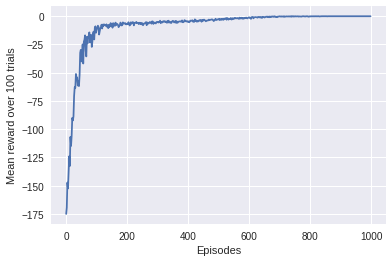

In [12]:
def paint(df):
    values = [(e, r) for e, r in dict(df.groupby('ep').rew.mean()).items()]
    values.sort(key=lambda x: x[0])
    v = np.array(values)
    plt.plot(v[:, 0], v[:, 1])
    plt.xlabel('Episodes')
    plt.ylabel('Mean reward over {:,} trials'.format(df.trial.max()+1))
    
paint(df)

## Position Tagging

We see that the agent can indeed be taught certain functions. It is not time to see if it can learn more complex functions. Here we try to teach it a function which depends only on position and not on the actual text.

In [16]:
def even_pos():
    letters = 'abcdefghijklmnopqrtuvwxyz'
    text = [random.choice(letters) for _ in range(1000)]
    labels = ['+' if (i%2==0) else '-' for i, letter in enumerate(text)]
    return text, labels

In [17]:
df = check_fn(even_pos)

50 actions
Runing even_pos
DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...







100%|██████████| 100/100 [01:11<00:00,  1.62it/s]

Experiments completed...
100 files
Reading files...


Painting...


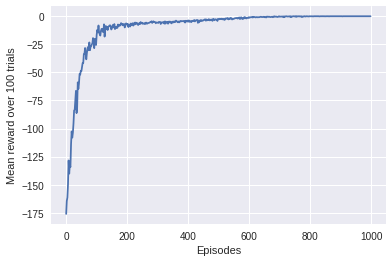

In [18]:
paint(df)

## Index and text

a task which depends on both index and task

In [19]:
def postext():
    letters = 'abcdefghijklmnopqrtuvwxyz'
    text = [random.choice(letters) for _ in range(1000)]
    labels = ['+' if ((i%2==0) and letter in 'abc') else '-' for i, letter in enumerate(text)]
    return text, labels

In [20]:
df = check_fn(postext)

50 actions
Runing postext
DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...


100%|██████████| 100/100 [01:07<00:00,  2.34it/s]


Experiments completed...
100 files
Reading files...


Painting...


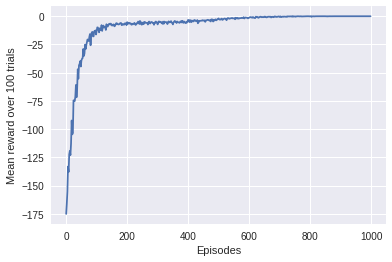

In [21]:
paint(df)


## Actual tasks

We see that these tasks converge to the theoretical max of 0. At this time we are confident enough to try and approach real tasks for this method. We will attempt to perform POS tagging on some corpus

In [22]:
def sorting():
    letters = 'abcdefghijklmnopqrtuvwxyz'
    text = [random.choice(letters) for _ in range(10)]
    labels = list(sorted(text))
    return text, labels

In [26]:
n_comm = 10
letters = 'abcdefghijklmnopqrtuvwxyz'
actions = [(a, i)
           for i in range(n_comm)
           for letter in letters
           for a in ['<', '>', 'write'+letter]]
actions += [('STOP', i) for i in range(n_comm)]
actions = list(set(actions))

wo = [TL(sorting, actions)]
ag = [QLAgent(actions)]
print('{:,} actions'.format(len(actions)))
print('Runing {}'.format(sorting.__name__))

280 actions
Runing sorting


In [27]:
! rm -rf DataDir/
paths = benchmark(ag, wo, 500, None, 100)
df = make_df(paths)

DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...







 36%|███▌      | 36/100 [20:09<27:32, 25.81s/it]  Process ForkPoolWorker-49:
Process ForkPoolWorker-51:
Process ForkPoolWorker-52:
Process ForkPoolWorker-50:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/arjoonn/Desktop/rlagents/rlagents/tools.py", lin

Stopping Experiments...
36 files
Reading files...






  0%|                                                    | 0/36 [00:00<?, ?it/s]

                                                                                

Painting...


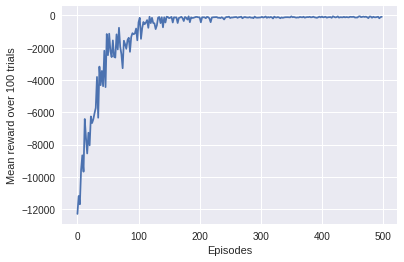

In [29]:
paint(df)